# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
#!pip install wandb
#!pip3 install pytorch_lightning torchmetrics

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 9.0 MB/s 


In [2]:
import math
import os
import random
import sys

from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
#import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
#from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need

In [3]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-08 15:20:45--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-08 15:20:46--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0fe216c4e968ce3c68759804d2.dl.dropboxusercontent.com/cd/0/get/BwUj0T6rlZqBuRe_jGPKZ5ArS2ydNod2MyAWuiUd6lUaKxFxxfFmN5wwGKQtm-fhUNwcvn0QPyWYNEPBk3EqVwc0K14p1wCFEAwcCfDRrakJt5htG3ZMr8hE3UsNFfOWLi46DLLum0c3PlgfcYieziKWVNDUDfpKp7DINkFN03dTUw/file?dl=1# [following]
--2022-11-08 15:20:46--  https://uc0fe216c4e968ce3c68759804d2.dl.dropboxusercontent.com/cd/0/get/BwUj0T6rlZqBuRe_jGPKZ5ArS2ydNod2MyAWuiUd6lUaKxFxxfFmN5wwGKQtm-fhUNwcvn0QPyWYNE

In [6]:
import PIL

bs = 64

train_transform = transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
val_transform = transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=bs,
    shuffle=True, 
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=bs,
    shuffle=False, 
    num_workers=1
)

In [7]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

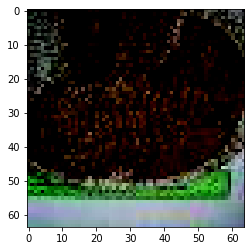

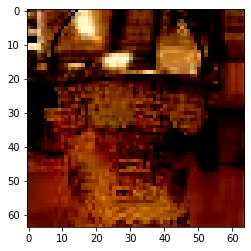

tensor([ 92, 141, 185,  69, 155,  51, 173,  45, 180,  36, 195, 127,  75, 140,
         88, 107, 149, 155,   4, 194,  60, 152, 109,  80,  22,  55,  15, 128,
        129,  34, 175,  59, 118, 107, 114, 168, 182, 198, 165, 140, 195, 123,
        106,   3,   6, 172,  36, 152, 128, 192,  90, 124, 127, 185, 112, 166,
         86, 116,  80,  19,  86, 163,  83,  70])


In [8]:
i = 0
for batch in train_dataloader:
    i+=1
    images, class_nums = batch
    plt.imshow(images[3].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[4].permute(1, 2, 0))
    plt.show()
    print(class_nums)
    if i == 1:
        break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

In [9]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    ep = np.argmax(val_history)

    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val: {:.2f}".format(val_history[-1]), zorder=2)
    plt.scatter(steps[ep], val_history[ep], marker='+', s=180, c="red", label="val_best: {:.2f}".format(val_history[ep]), zorder=2)

    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

### Модель (или просто импортируйте не предобученную)

In [10]:
##  0.43  ##

class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.vgg1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
        )
        self.vgg2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
        )
        self.vgg3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 64 * 2, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(400, 200),

        )
        # self.softmax = nn.Softmax()

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

        
    def _forward(self, x):
        x = self.vgg1(x)
        x = self.vgg2(x)
        x = self.vgg3(x)
        x = self.fc(x)
        # x = self.softmax(self.fc2(x))
        return x
  

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is None:
            return output

        if target is not None:
            loss = self.loss_func(output, target)
            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy_score(self.preds.long(), self.targets.long())

            return loss
    
    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [16]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    
    for epoch in range(n_epochs):

        train_predicted_classes = torch.Tensor([]).to(device)
        train_true_classes = torch.Tensor([]).to(device)
    
        val_predicted_classes = torch.Tensor([]).to(device)
        val_true_classes = torch.Tensor([]).to(device)

        # тренировка
        model.train()

        if epoch == 0:
            for g in optimizer.param_groups:
                g['lr'] = 0.0015
        if epoch == 5:
            for g in optimizer.param_groups:
                g['lr'] = 0.001 
        if epoch == 10:
            for g in optimizer.param_groups:
                g['lr'] = 0.0005 
        if epoch == 15:
            for g in optimizer.param_groups:
                g['lr'] = 0.0002
        if epoch == 18:
            for g in optimizer.param_groups:
                g['lr'] = 0.00005 


        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            if labels.size()[0] != bs:
                    continue
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)

            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels.cpu()).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])


        # валидация

        model.eval()

        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))

                pred_classes = torch.argmax(y_pred, dim=-1)

                val_predicted_classes = torch.cat((val_predicted_classes, pred_classes), 0)
                val_true_classes = torch.cat((val_true_classes, labels), 0)


        
        acc_val = accuracy_score(val_predicted_classes.cpu().detach().numpy(), val_true_classes.cpu().detach().numpy())
        

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(acc_val)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:", 
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print("Val acc:", acc_val)

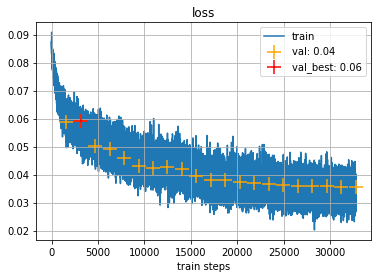

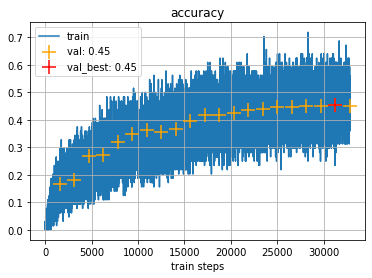

Train loss: 0.033513739705085754
Train acc: 0.46357834339141846
Val loss: 0.035682059824466705
Val acc: 0.4523


In [18]:
model1 = MyNet().to(device)     
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0015)

train(model1, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=21)

### Валидация результатов задания

In [14]:
def evaluate_task(model, test_dataloader, device=device):
    model = model.to(device)
    accuracy = 0.0
    model.eval()
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [19]:
model = model1
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 157/157 [00:06<00:00, 23.11it/s]

Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import PIL

bs = 64

transforms.Compose([
    transforms.Resize((299,299)),
    #transforms.CenterCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
)
val_transform = transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=bs,
    shuffle=True, 
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=bs,
    shuffle=False, 
    num_workers=1
)

In [ ]:
class MyResnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Sequential(
            nn.Linear(512, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(400, 200),
        )

        self.model = inception
        self.model.fc = nn.Identity()
        self.classifier = nn.Linear(1000, 200)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        return preds


In [ ]:
Net = MyResnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.0015)

train(Net, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=15)

RuntimeError: ignored

### Валидация результатов задания

In [ ]:
model = # Подгрузить свою сохраненную модель сюда

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

SyntaxError: ignored

# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.